# K. McCulloch - HWRS 564B - HW 2

## Model Description:
This model represents the area around the Wildcat Farm (30 ac. cotton farm) and ACME Farm (500 ac alfalfa farm) in Arizona. The model includes representation of pumping at Wildcat Farm (one well) and ACME Farm (two wells) under three scenarios:
1. Baseline: Wildcat Farm's total pumping is equivalent to the consumptive water use for cotton in Arizona over the area of the farm. ACME Farm's total pumping is equivalent to the consumptive water use for alfalfa in Arizona over the area of the farm. ACME Farm wells are located in the middle of the farm.
2. Worst-Case Scenario: Same pumping rates as baseline. ACME Farm wells are located at the edge of the farm closest to Wildcat Farm.
3. Best-Case Scenario: Same pumping rates as baseline. ACME Farm wells are located at the edge of the farm furthest from Wildcat Farm.

#### Dimensions: 
- 27 rows by 27 column by 1 layer
- dx = dy = 100 m
- dz = 300 m  

#### Heterogeneous Subsurface Properties: 
- K [m/day] = 1.5 (top left), 1 (top right), 13 (bottom left), 8.4 (bottom right)
- Porosity [fraction] = 0.35
- Specific Yield [-] = 0.3
- Specific Storage [1/m] = 0.001  

#### Boundary Conditions: 
 - Left boundary is constant head starting from 4.8 m below ground surface (m-bgs) at the top left to 5.4 m-bgs at the bottom left
 - Right boundary is constant head starting from 50.2 m-bgs at the top right to 51.6 m-bgs at the bottom right

### Setup the environment

In [1]:
# the basics
import flopy
import numpy as np
import matplotlib as mp
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from flopy.utils import CellBudgetFile, HeadFile
import os
import shutil
import time
import copy
import math

# additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

# jupyter specific--included to show plots in notebook
%matplotlib inline 

### Create the model object

In [2]:
modelname = "HW2"
moddir = '../../../modflow/mf2005'
m = flopy.modflow.Modflow(modelname, exe_name = moddir)
#moddir = os.getcwd()+"\\modflowdir\\mf2005.exe"


In [3]:
# optional delete old run files
run = 'n'
if run == 'y':
    file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    for ext in file_extensions:
        os.remove(modelname + ext)

### Setup the discretization (DIS package)

In [4]:
# spatial discretization

nrow = 27 # number of rows
ncol = 27 # number of columns
nlay = 1  # number of layers

dx = 100 # width of grid cells in x direction 
dy = 100 # width of grid cells in y direction 

Lx = ncol*dx  # width of domain in x
Ly = nrow*dy # width of domain in y
ztop = 300    # top elevation (equivalent to max screen depth of ACME Farm wells * 1.5)
zbot = 0    # bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

In [5]:
# temporal discretization

nper = 1 #number of stress periods 
steady = [True] # list noting the stress period type

In [6]:
#  flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                                                              itmuni = 4, lenuni = 2, 
                                                                                             nper=nper, steady=steady)

#### Plot the grid and farms

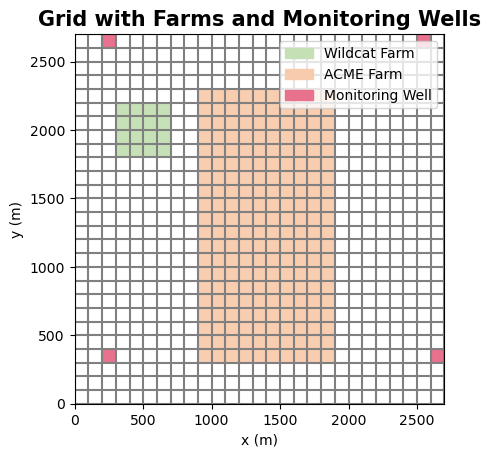

In [7]:
# initialize array: 0 = background, 1 = Wildcat Farm, 2 = ACME Farm
farm_array = np.zeros((nrow, ncol), dtype=int)

# dimensions of wildcat farm
r1_a, r2_a = 5, 8
c1_a, c2_a = 3, 6

# dimensions of acme farm
r1_b, r2_b = 4, 23
c1_b, c2_b = 9, 18

# fill array (note slice end is +1 because ranges are inclusive)
farm_array = np.zeros((nrow, ncol), dtype=int)
farm_array[r1_a:r2_a + 1, c1_a:c2_a + 1] = 1
farm_array[r1_b:r2_b + 1, c1_b:c2_b + 1] = 2

# coordinates of monitoring wells
mwells = [(0, 2), (0, 25), (23, 2), (23, 26)]

mw = np.zeros((nrow, ncol), dtype=int)
for r, c in mwells:
    if 0 <= r < nrow and 0 <= c < ncol:
        mw[r, c] = 1
    else:
        print(f"Warning: monitoring well {(r,c)} is outside the grid and was skipped") # qc check

# colors
farm_colors = [
    (0.0, 0.0, 0.0, 0.0),  # transparent
    "#c5e0b4",             # farm A (index 1)
    "#f8cbad"              # farm B (index 2)
]
farm_cmap = ListedColormap(farm_colors)
farm_norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], farm_cmap.N)

well_colors = [
    (0.0, 0.0, 0.0, 0.0),  # transparent
    "#e8718d"              # well color (index 1)
]
well_cmap = ListedColormap(well_colors)
well_norm = BoundaryNorm([-0.5, 0.5, 1.5], well_cmap.N)

# plot
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
modelmap.plot_array(farm_array, masked_values=[0], cmap=farm_cmap, norm=farm_norm, alpha=0.8)
modelmap.plot_array(mw, masked_values=[0], cmap=well_cmap, norm=well_norm, alpha=1.0)
modelmap.plot_grid()

plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Model Grid with Farms and Monitoring Wells', fontsize = 15, fontweight = 'bold')

farmA_patch = mpatches.Patch(color=farm_colors[1], label='Wildcat Farm')
farmB_patch = mpatches.Patch(color=farm_colors[2], label='ACME Farm')
well_patch = mpatches.Patch(color=well_colors[1], label='Monitoring Well')

# legend and labels
plt.legend(handles=[farmA_patch, farmB_patch, well_patch], loc='upper right')
plt.xlabel('x (m)', fontsize=10)
plt.ylabel('y (m)', fontsize=10)
plt.title('Grid with Farms and Monitoring Wells', fontsize=15, fontweight='bold')
plt.show()

### Setup constant head boundaries, active cells and initial heads (BAS Package)

In [8]:
ibound = np.ones((nlay, nrow, ncol), dtype=int)   # start with all active

#  # set no-flow on top and bottom rows (all layers)
# ibound[:, 0, :]  = 0    # top row
# ibound[:, -1, :] = 0    # bottom row

# set constant-head on left and right columns (all layers)
ibound[:, :, 0]  = -1   # leftmost column
ibound[:, :, -1] = -1   # rightmost column

# corner cells are constant-head (overwrite any no-flow assigned above)
ibound[:, 0, 0]   = -1  # top-left
ibound[:, 0, -1]  = -1  # top-right
ibound[:, -1, 0]  = -1  # bottom-left
ibound[:, -1, -1] = -1  # bottom-right

# qc check
print("Left column (top to bottom):", np.round(ibound[0, :, 0]))
print("Right column(top to bottom):", np.round(ibound[0, :, -1]))
print("Top row   (left to right):  ", np.round(ibound[0, 0, :]))
print("Bottom row(left to right):  ", np.round(ibound[0, -1, :]))

Left column (top to bottom): [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]
Right column(top to bottom): [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]
Top row   (left to right):   [-1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1]
Bottom row(left to right):   [-1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1]


In [9]:
# constant initial heads = ztop
H_init = np.full((nlay, nrow, ncol), ztop, dtype=np.float32)   

# computed with excel
f_tl = 295.2   # top-left
f_tr = 249.8   # top-right
f_bl = 289.3   # bottom-left
f_br = 243.7   # bottom-right

top_vals    = np.linspace(f_tl, f_tr, ncol)  # left to right across top
bottom_vals = np.linspace(f_bl, f_br, ncol)  # left to right across bottom
left_vals   = np.linspace(f_tl, f_bl, nrow)  # top to bottom down left
right_vals  = np.linspace(f_tr, f_br, nrow)  # top to bottom down right

st_rt = np.zeros_like(H_init, dtype=np.float32)

for k in range(nlay):
    st_rt[k, :, 0]  = left_vals    # entire left column (rows top to bottom)
    st_rt[k, :, -1] = right_vals   # entire right column

if ncol > 2:
    for k in range(nlay):
        st_rt[k, 0, 1:-1]  = top_vals[1:-1]    # top row, interior columns
        st_rt[k, -1, 1:-1] = bottom_vals[1:-1] # bottom row, interior columns

# explicitly enforce corner values
st_rt[:, 0, 0]   = f_tl
st_rt[:, 0, -1]  = f_tr
st_rt[:, -1, 0]  = f_bl
st_rt[:, -1, -1] = f_br

# qc check
print("Left column (top to bottom):", np.round(st_rt[0, :, 0], 1))
print("Right column(top to bottom):", np.round(st_rt[0, :, -1], 1))

Left column (top to bottom): [295.2 295.  294.7 294.5 294.3 294.1 293.8 293.6 293.4 293.2 292.9 292.7
 292.5 292.2 292.  291.8 291.6 291.3 291.1 290.9 290.7 290.4 290.2 290.
 289.8 289.5 289.3]
Right column(top to bottom): [249.8 249.6 249.3 249.1 248.9 248.6 248.4 248.2 247.9 247.7 247.5 247.2
 247.  246.8 246.5 246.3 246.  245.8 245.6 245.3 245.1 244.9 244.6 244.4
 244.2 243.9 243.7]


In [10]:
# create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### Plot the grid, boundary conditions, and pumping wells

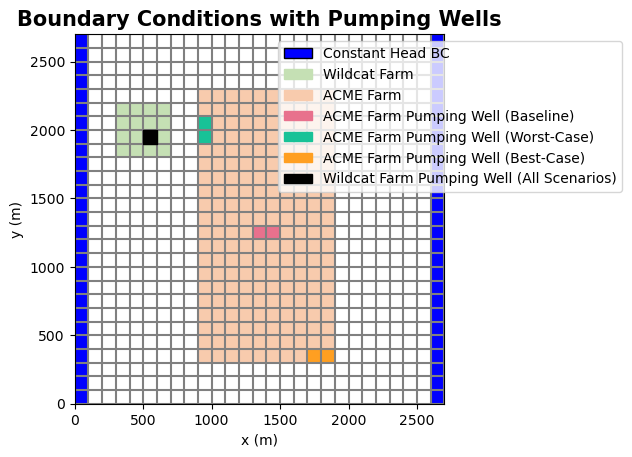

In [11]:
# dimensions of wildcat farm
r1_a, r2_a = 5, 8
c1_a, c2_a = 3, 6

# dimensions of acme farm
r1_b, r2_b = 4, 23
c1_b, c2_b = 9, 18

# fill array (note slice end is +1 because ranges are inclusive)
farm_array = np.zeros((nrow, ncol), dtype=int)
farm_array[r1_a:r2_a + 1, c1_a:c2_a + 1] = 1
farm_array[r1_b:r2_b + 1, c1_b:c2_b + 1] = 2

# coordinates of pumping wells
pump_all = np.zeros((nrow, ncol), dtype=int)
pumping_wells = [(7, 5), (14, 13), (14, 14)]
pumping_wells_wc = [(7, 5), (6, 9), (7, 9)]
pumping_wells_bc = [(7, 5), (23, 17), (23, 18)]

# baseline
for r, c in pumping_wells:
    if 0 <= r < nrow and 0 <= c < ncol:
        pump_all[r, c] = 1

# worst-case
for r, c in pumping_wells_wc:
    if 0 <= r < nrow and 0 <= c < ncol:
        pump_all[r, c] = 2

# worst-case
for r, c in pumping_wells_bc:
    if 0 <= r < nrow and 0 <= c < ncol:
        pump_all[r, c] = 3

pump_array_wc = np.zeros((nrow, ncol), dtype=int)
for r, c in pumping_wells_wc:
    if 0 <= r < nrow and 0 <= c < ncol:
        pump_array_wc[r, c] = 1
    else:
        print(f"Warning: pumping well {(r,c)} is outside the grid and was skipped")

# best-case
pumping_wells_bc = [(7, 5), (23, 17), (23, 18)]

pump_array_bc = np.zeros((nrow, ncol), dtype=int)
for r, c in pumping_wells_bc:
    if 0 <= r < nrow and 0 <= c < ncol:
        pump_array_bc[r, c] = 1
    else:
        print(f"Warning: pumping well {(r,c)} is outside the grid and was skipped")

# colors
farm_colors = [
    (0.0, 0.0, 0.0, 0.0),  # transparent
    "#c5e0b4",             # farm A (index 1)
    "#f8cbad"              # farm B (index 2)
]
farm_cmap = ListedColormap(farm_colors)
farm_norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], farm_cmap.N)

pump_colors = [
    (0.0, 0.0, 0.0, 0.0),  # transparent
    "#e8718d",              # baseline
    "#18C297",              # worst-case
    "#ff9f21",              # best-case
]

pump_cmap = ListedColormap(pump_colors)
pump_norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], pump_cmap.N)

# plot farms and ACME Farm pumping wells
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
ib = modelmap.plot_ibound()
modelmap.plot_array(farm_array, masked_values=[0], cmap=farm_cmap, norm=farm_norm, alpha=1.0, zorder=2)
modelmap.plot_array(pump_all, masked_values=[0], cmap=pump_cmap, norm=pump_norm, alpha=1.0, zorder=2)
grid = modelmap.plot_grid()

# plot Wildcat Farm pumping well
xgrid = np.linspace(dx/2, dx*ncol - dx/2, ncol)
ygrid = np.linspace(dy/2, dy*nrow - dy/2, nrow)
def y_of_row(r):
    return ygrid[nrow - 1 - r]
well_r, well_c = 7, 5
well_x = xgrid[well_c]
well_y = y_of_row(well_r)

ax = modelmap.ax
ax.scatter(well_x, well_y,
           s=100,              # marker size (adjust as desired)
           c='k',              # fill color black
           marker='s',         # square marker
           edgecolors='black', 
           linewidths=1.0,
           zorder=10)

# legend and labels
plt.xlabel('x (m)',fontsize = 10)
plt.ylabel('y (m)',fontsize = 10)
plt.title('Boundary Conditions with Pumping Wells', fontsize = 15, fontweight = 'bold')

handles = [
    mpatches.Patch(color='blue',  label='Constant Head BC', ec='black'),
    # mpatches.Patch(color='white', label='Active Cell', ec='black'),
    # mpatches.Patch(color='black', label='No-Flow BC', ec='black'),
    mpatches.Patch(color="#c5e0b4", label=f'Wildcat Farm'),
    mpatches.Patch(color="#f8cbad", label=f'ACME Farm'),
    mpatches.Patch(color="#e8718d", label='ACME Farm Pumping Well (Baseline)'),
    mpatches.Patch(color="#18C297", label='ACME Farm Pumping Well (Worst-Case)'),
    mpatches.Patch(color="#ff9f21", label='ACME Farm Pumping Well (Best-Case)'),
    mpatches.Patch(color='k', label='Wildcat Farm Pumping Well (All Scenarios)')
]

plt.legend(handles=handles, bbox_to_anchor=(1.5, 1.0))
plt.show()

### Setup Cell-byCell Properties  (BCF Package)

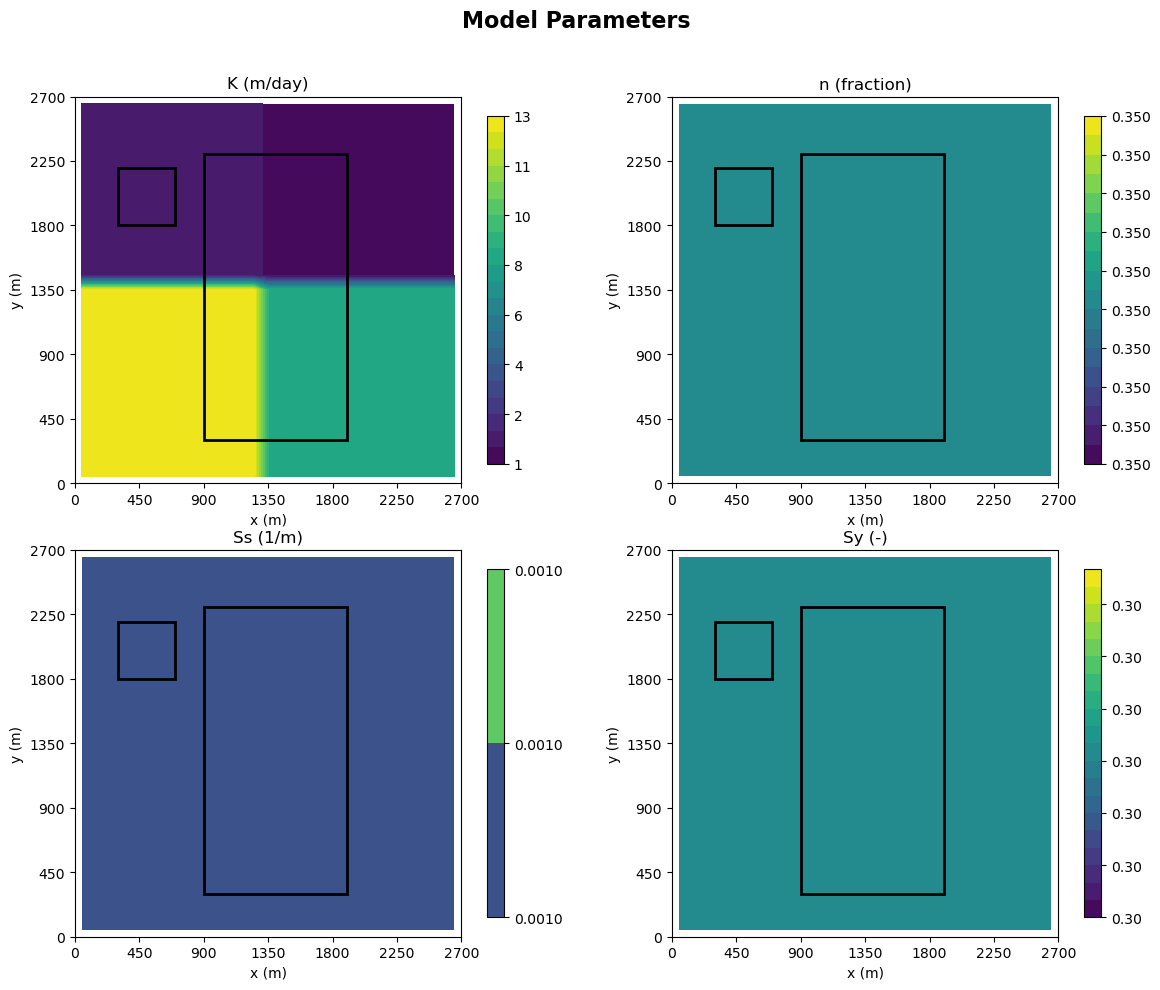

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle

# cell-center coordinates in physical units
xgrid = np.linspace(dx/2, dx*ncol - dx/2, ncol)  # centers in x (m)
ygrid = np.linspace(dy/2, dy*nrow - dy/2, nrow)  # centers in y (m)
X, Y = np.meshgrid(xgrid, ygrid)

# helper to map row index to physical y (top-origin)
def y_of_row(r):
    return ygrid[nrow - 1 - r]

n = 0.35
Ss = 0.001
Sy = 0.3

r_mid = nrow // 2
c_mid = ncol // 2

K_vals = np.zeros((1, nrow,ncol), dtype=np.float32)

K_vals[:, :r_mid, :c_mid] = 1.5 #top left
K_vals[:, :r_mid, c_mid:] = 1 #top right
K_vals[:, r_mid:, :c_mid] = 13 #bottom left
K_vals[:, r_mid:, c_mid:] = 8.4 #bottom right


# prepare arrays (layer 0)
layer = 0
K_top  = K_vals[layer, :, :]
n_top  = np.full((nrow, ncol), n)
Ss_top = np.full((nrow, ncol), Ss)
Sy_top = np.full((nrow, ncol), Sy)

plots = [
    (K_top,  'K (m/day)', 'viridis'),
    (n_top,  'n (fraction)', 'viridis'),
    (Ss_top, 'Ss (1/m)', 'viridis'),
    (Sy_top, 'Sy (-)', 'viridis'),
]

# formatter functions for the colorbars
formatters = {
    'K (m/day)':       FuncFormatter(lambda x, pos: f"{int(round(x))}"),
    'n (fraction)':    FuncFormatter(lambda x, pos: f"{x:.3f}"),
    'Ss (1/m)':        FuncFormatter(lambda x, pos: f"{x:.4f}"),
    'Sy (-)':   FuncFormatter(lambda x, pos: f"{x:.2f}"),
}

# compute farm rectangle positions (physical coords)
farm_left = xgrid[c1_a] - dx/2
farm_bottom = y_of_row(r2_a) - dy/2
farm_width = (c2_a - c1_a + 1) * dx
farm_height = (r2_a - r1_a + 1) * dy

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for ax, (arr, title, cmap) in zip(axs, plots):
    # flip if row 0 is top so Y increases upward
    Z_plot = np.flipud(arr)

    # contourf using physical X,Y (cell centers)
    im = ax.contourf(X, Y, Z_plot, cmap=cmap, levels=20)

    # set axis limits to full model footprint
    ax.set_xlim(0.0, dx * ncol)
    ax.set_ylim(0.0, dy * nrow)

    # ticks in meters (7 ticks across)
    xticks = np.linspace(0.0, dx * ncol, 7)
    yticks = np.linspace(0.0, dy * nrow, 7)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([f"{int(t):d}" for t in xticks])
    ax.set_yticklabels([f"{int(t):d}" for t in yticks])

    ax.set_title(title, fontsize=12)
    ax.set_xlabel('x (m)', fontsize=10)
    ax.set_ylabel('y (m)', fontsize=10)
    ax.set_aspect('equal')

    ax.add_patch(Rectangle((farm_left, farm_bottom), farm_width, farm_height,
                       linewidth=2, edgecolor='k', facecolor='none', zorder=10))
    farmB_left = xgrid[c1_b] - dx/2
    farmB_bottom = y_of_row(r2_b) - dy/2
    farmB_width = (c2_b - c1_b + 1) * dx
    farmB_height = (r2_b - r1_b + 1) * dy
    ax.add_patch(Rectangle((farmB_left, farmB_bottom), farmB_width, farmB_height,
                       linewidth=2, edgecolor='k', facecolor='none', zorder=10))

    # colorbar for this panel
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.9)
    # set tick formatter according to the requested precision
    fmt = formatters.get(title, None)
    if fmt is not None:
        cbar.ax.yaxis.set_major_formatter(fmt)

fig.suptitle('Model Parameters', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [13]:
# assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=1, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[0,:,:], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


### Setup outputs by stress period

In [14]:
# create oc stress period data. 
# (0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


### Make OC object 

In [15]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

### Set the numerical solver (PCG Package)

In [16]:
pcg = flopy.modflow.ModflowPcg(model=m)

#### Setup recharge

In [17]:
default_rech = 0.0001
farm_rech = 0.0

# dimensions of wildcat farm
r1_a, r2_a = 5, 8
c1_a, c2_a = 3, 6

# dimensions of acme farm
r1_b, r2_b = 4, 23
c1_b, c2_b = 9, 18

# create rech array filled with the default value
rech_zone = np.full((nrow, ncol), default_rech, dtype=float)

# assign farm recharge values (slicing end is +1 because ranges are inclusive)
rech_zone[r1_a:r2_a + 1, c1_a:c2_a + 1] = farm_rech
rech_zone[r1_b:r2_b + 1, c1_b:c2_b + 1] = farm_rech

# qc check
unique, counts = np.unique(rech_zone, return_counts=True)
print("Recharge values in grid:", dict(zip(unique, counts)))

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, nrchop=3, ipakcb=53)     # create rch object

Recharge values in grid: {np.float64(0.0): np.int64(216), np.float64(0.0001): np.int64(513)}


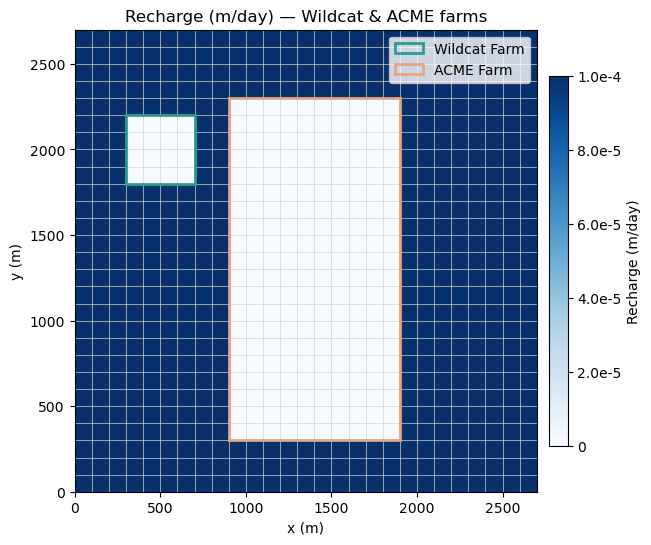

In [18]:
# physical cell centers and edges
xcent = np.linspace(dx/2, dx*ncol - dx/2, ncol)
ycent = np.linspace(dy/2, dy*nrow - dy/2, nrow)
Xc, Yc = np.meshgrid(xcent, ycent)

xedges = np.linspace(0.0, dx * ncol, ncol + 1)
yedges = np.linspace(0.0, dy * nrow, nrow + 1)

# helper for top-origin row to physical y
def y_of_row(r):
    return ycent[nrow - 1 - r]

# flip recharge for plotting so y increases upward
Z = np.flipud(rech_zone)

# farm rectangles in physical coords (top-origin to bottom computed using r2)
farmA_left = xcent[c1_a] - dx/2
farmA_bottom = y_of_row(r2_a) - dy/2
farmA_w = (c2_a - c1_a + 1) * dx
farmA_h = (r2_a - r1_a + 1) * dy

farmB_left = xcent[c1_b] - dx/2
farmB_bottom = y_of_row(r2_b) - dy/2
farmB_w = (c2_b - c1_b + 1) * dx
farmB_h = (r2_b - r1_b + 1) * dy

# plotting
fig, ax = plt.subplots(figsize=(8, 6))

# use pcolormesh with cell edges (shading='auto' handles dimension alignment)
pcm = ax.pcolormesh(xedges, yedges, Z, cmap='Blues', shading='auto')

# model grid (thin lines)
for xe in xedges:
    ax.axvline(x=xe, color='lightgray', linewidth=0.5, zorder=1)
for ye in yedges:
    ax.axhline(y=ye, color='lightgray', linewidth=0.5, zorder=1)

# farm outlines
ax.add_patch(Rectangle((farmA_left, farmA_bottom), farmA_w, farmA_h,
                       linewidth=2, edgecolor='#2a9d8f', facecolor='none', zorder=5, label='Wildcat Farm'))
ax.add_patch(Rectangle((farmB_left, farmB_bottom), farmB_w, farmB_h,
                       linewidth=2, edgecolor='#e6a57e', facecolor='none', zorder=5, label='ACME Farm'))

# axis labels and title
ax.set_xlim(0.0, dx * ncol)
ax.set_ylim(0.0, dy * nrow)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Recharge (m/day) — Wildcat & ACME farms')

# colorbar: format ticks in scientific notation if values are small
def sci_formatter(x, pos):
    # show small numbers compactly, e.g. 1e-4
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    mant = x / 10**exponent
    return f"{mant:.1f}e{exponent}"
cbar = fig.colorbar(pcm, ax=ax, shrink=0.8, pad=0.02)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(sci_formatter))
cbar.set_label('Recharge (m/day)')

# legend for farms
ax.legend(loc='upper right')

plt.show()

#### Add wells

In [19]:
wells_baseline = [
    (0, 7, 5,  464.0),
    (0, 14, 13, 5200.0),
    (0, 14, 14, 5200.0)
]

wc_coords = [(0, 7, 5), (0, 6, 9), (0, 7, 9)]         # worst-case coords
bc_coords = [(0, 7, 5), (0, 23, 17), (0, 23, 18)]     # best-case coords

default_small_q = 464.0
default_large_q = 5200.0

# convert (k,r,c,q) list into flopy-wel entries (with negative extraction rates)
def build_wel_entries(wells_krcq, nlay, nrow, ncol):
    wel_list = []
    skipped = []
    for k, r, c, q in wells_krcq:
        if not (0 <= k < nlay and 0 <= r < nrow and 0 <= c < ncol):
            skipped.append((k, r, c))
            continue
        wel_list.append([int(k), int(r), int(c), -float(q)])   # negative = extraction in flopy
    return wel_list, skipped

# build wells from coords-only list, mapping default q's
def assign_qs_to_coords(coords_list, q_map=None, default_large=5200.0, default_small=464.0):
    """
    coords_list: list of (k,r,c)
    q_map: optional dict {(k,r,c): q} to explicitly set rates for particular coords
    heuristic: if coordinate equals (0,7,5) -->> RF small well, else -->> large well (unless q_map overrides)

    """
    q_map = q_map or {}
    wells_krcq = []
    for (k, r, c) in coords_list:
        if (k, r, c) in q_map:
            q = q_map[(k, r, c)]
        elif (k, r, c) == (0, 7, 5):
            q = default_small
        else:
            q = default_large
        wells_krcq.append((k, r, c, q))
    return wells_krcq

wells_wc = assign_qs_to_coords(wc_coords, default_large=default_large_q, default_small=default_small_q)
wells_bc = assign_qs_to_coords(bc_coords, default_large=default_large_q, default_small=default_small_q)
wel_baseline_list, skipped_baseline = build_wel_entries(wells_baseline, nlay, nrow, ncol)
wel_wc_list, skipped_wc = build_wel_entries(wells_wc, nlay, nrow, ncol)
wel_bc_list, skipped_bc = build_wel_entries(wells_bc, nlay, nrow, ncol)

sp_fluxes_baseline = {0: wel_baseline_list}
sp_fluxes_wc       = {0: wel_wc_list}
sp_fluxes_bc       = {0: wel_bc_list}
           
# qc check
print(sp_fluxes_baseline)
print(sp_fluxes_wc)
print(sp_fluxes_bc)

{0: [[0, 7, 5, -464.0], [0, 14, 13, -5200.0], [0, 14, 14, -5200.0]]}
{0: [[0, 7, 5, -464.0], [0, 6, 9, -5200.0], [0, 7, 9, -5200.0]]}
{0: [[0, 7, 5, -464.0], [0, 23, 17, -5200.0], [0, 23, 18, -5200.0]]}


In [20]:
base_ws = os.path.abspath("mf_runs")   # adjust if your scenario folders are elsewhere
model_base_name = m.name if getattr(m, 'name', None) else "model"
scenarios = ["baseline", "worst", "best"]

# map scenario flux dicts so we can show expected wells
sp_map = {"baseline": sp_fluxes_baseline, "worst": sp_fluxes_wc, "best": sp_fluxes_bc}

def find_file_in_folder(folder, ext):
    """Return first filename in folder that endswith ext (case-insensitive) or None."""
    if not os.path.isdir(folder):
        return None
    for fn in os.listdir(folder):
        if fn.lower().endswith(ext.lower()):
            return os.path.join(folder, fn)
    return None

for scen in scenarios:
    scen_ws = os.path.join(base_ws, scen)
    print(f"\n=== Scenario: {scen} (folder: {scen_ws}) ===")
    if not os.path.isdir(scen_ws):
        print("  Folder not found. Skipping.")
        continue

    # Prefer the filename listed in the NAME file if present (optional)
    nam = os.path.join(scen_ws, f"{model_base_name}_{scen}.nam")
    hds_path = None
    cbc_path = None
    if os.path.isfile(nam):
        with open(nam, 'r', errors='ignore') as fh:
            for line in fh:
                L = line.strip().upper()
                if L.startswith("DATA(BINARY)"):
                    toks = line.split()
                    if len(toks) >= 3:
                        fname = toks[2].strip()
                        if fname.lower().endswith('.hds'):
                            cand = os.path.join(scen_ws, toks[2])
                            if os.path.isfile(cand):
                                hds_path = cand
                        if fname.lower().endswith('.cbc') or fname.lower().endswith('.bud'):
                            cand = os.path.join(scen_ws, toks[2])
                            if os.path.isfile(cand):
                                cbc_path = cand

    # fallback: find any .hds/.cbc files in that folder
    if hds_path is None:
        hds_path = find_file_in_folder(scen_ws, ".hds")
    if cbc_path is None:
        # some runs use .cbc or .bud extension
        cbc_path = find_file_in_folder(scen_ws, ".cbc") or find_file_in_folder(scen_ws, ".bud")

    print(" HDS:", bool(hds_path), "->", hds_path)
    print(" CBC:", bool(cbc_path), "->", cbc_path)

    # Read and summarize HDS if present
    if hds_path:
        try:
            hf = HeadFile(hds_path)
            kstpkper = hf.get_kstpkper()
            if kstpkper:
                head_arr = hf.get_data(kstpkper=kstpkper[-1])
                if isinstance(head_arr, list):
                    head_arr = head_arr[0]
                print(f"  HDS last record {kstpkper[-1]}: shape={head_arr.shape}, min={head_arr.min():.4f}, max={head_arr.max():.4f}, mean={head_arr.mean():.4f}")
            else:
                print("  HDS has no records.")
        except Exception as e:
            print("  Error reading HDS:", e)


=== Scenario: baseline (folder: /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/baseline) ===
 HDS: True -> /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/baseline/HW2.hds
 CBC: True -> /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/baseline/HW2.cbc
  HDS last record (np.int32(0), np.int32(0)): shape=(1, 27, 27), min=297.0290, max=300.0000, mean=299.3547

=== Scenario: worst (folder: /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/worst) ===
 HDS: True -> /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/worst/HW2.hds
 CBC: True -> /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/worst/HW2.cbc
  HDS last record (np.int32(0), np.int32(0)): shape=(1, 27, 27), min=286.3044, max=300.0000, mean=298.4300

=== Scena

##### Write Heads as csv

In [21]:
# with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
#     writer = csv.writer(csvfile, delimiter=',')        
#     for i in range(len(head[0,:,0])):                    #writes each row
#         writer.writerow(head[0,i,:])


##### Read the Water Balance and use it to find distribution of fluxes along boundary

In [22]:
# set where your scenario folders live
base_ws = os.path.abspath("mf_runs")   # adjust if yours is elsewhere
model_base_name = m.name if getattr(m, 'name', None) else "model"
scenarios = ["baseline", "worst", "best"]

def find_file_in_folder(folder, ext):
    """Return first filename in folder that endswith ext or None."""
    if not os.path.isdir(folder):
        return None
    for fn in os.listdir(folder):
        if fn.lower().endswith(ext.lower()):
            return os.path.join(folder, fn)
    return None

for scen in scenarios:
    scen_ws = os.path.join(base_ws, scen)
    print(f"\n--- Scenario: {scen} (folder: {scen_ws}) ---")
    if not os.path.isdir(scen_ws):
        print(" Folder not found; skip.")
        continue

    # find hds/cbc in the scenario folder
    hds_path = find_file_in_folder(scen_ws, ".hds")
    cbc_path = find_file_in_folder(scen_ws, ".cbc") or find_file_in_folder(scen_ws, ".bud")

    print(" HDS:", bool(hds_path), "->", hds_path)
    print(" CBC:", bool(cbc_path), "->", cbc_path)

    # read head file (if exists) and show stats
    if hds_path:
        try:
            hf = HeadFile(hds_path)
            kstpkper = hf.get_kstpkper()
            print(" HDS records:", kstpkper)
            head_arr = hf.get_data(kstpkper=kstpkper[-1])[0]
            print(" head shape", head_arr.shape, "min/max/mean:", head_arr.min(), head_arr.max(), head_arr.mean())
        except Exception as e:
            print(" Error reading HDS:", e)


--- Scenario: baseline (folder: /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/baseline) ---
 HDS: True -> /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/baseline/HW2.hds
 CBC: True -> /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/baseline/HW2.cbc
 HDS records: [(np.int32(0), np.int32(0))]
 head shape (27, 27) min/max/mean: 297.02896 300.0 299.35474

--- Scenario: worst (folder: /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/worst) ---
 HDS: True -> /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/worst/HW2.hds
 CBC: True -> /workspaces/hwrs564b_course_materials_kfmcculloch98/content_weekly/Week3_WellsRecharge/mf_runs/worst/HW2.cbc
 HDS records: [(np.int32(0), np.int32(0))]
 head shape (27, 27) min/max/mean: 286.3044 300.0 298.42996

--- Scenario: be

### Process results to calculate drawdown

In [23]:
# config
base_ws = os.path.abspath("mf_runs")
model_base_name = m.name if getattr(m, 'name', None) else "model"
scenarios = ["baseline", "worst", "best"]

# helper to find an HDS in a folder (prefer name referenced in .nam)
def find_hds_for_scenario(scen):
    scen_ws = os.path.join(base_ws, scen)
    if not os.path.isdir(scen_ws):
        return None
    # try to parse .nam for DATA(BINARY) HDS name
    nam_path = os.path.join(scen_ws, f"{model_base_name}_{scen}.nam")
    if os.path.isfile(nam_path):
        with open(nam_path, 'r', errors='ignore') as fh:
            for line in fh:
                if line.strip().upper().startswith("DATA(BINARY)"):
                    toks = line.split()
                    if len(toks) >= 3 and toks[2].lower().endswith('.hds'):
                        candidate = os.path.join(scen_ws, toks[2].strip())
                        if os.path.isfile(candidate):
                            return candidate
    # fallback: find any .hds in folder
    for fn in os.listdir(scen_ws):
        if fn.lower().endswith('.hds'):
            return os.path.join(scen_ws, fn)
    return None

# populate heads_scenario
heads_scenario = {}   # fresh
for scen in scenarios:
    hds_path = find_hds_for_scenario(scen)
    if hds_path:
        try:
            hf = HeadFile(hds_path)
            kstpkper = hf.get_kstpkper()
            if not kstpkper:
                print(f"[{scen}] HDS found but no records: {hds_path}. Using fallback in-memory head.")
                heads_scenario[scen] = head.copy()
            else:
                data = hf.get_data(kstpkper=kstpkper[-1])
                arr = data[0] if isinstance(data, list) else data
                heads_scenario[scen] = arr.copy()
                print(f"[{scen}] Loaded HDS: {os.path.basename(hds_path)} shape {arr.shape}, min {arr.min():.4f}, max {arr.max():.4f}")
        except Exception as e:
            print(f"[{scen}] Error reading HDS {hds_path}: {e}. Using fallback in-memory head.")
            heads_scenario[scen] = head.copy()
    else:
        print(f"[{scen}] No HDS file found in {os.path.join(base_ws,scen)}. Using fallback in-memory head.")
        heads_scenario[scen] = head.copy()

print("heads_scenario keys now:", list(heads_scenario.keys()))

[baseline] Loaded HDS: HW2.hds shape (1, 27, 27), min 297.0290, max 300.0000
[worst] Loaded HDS: HW2.hds shape (1, 27, 27), min 286.3044, max 300.0000
[best] Loaded HDS: HW2.hds shape (1, 27, 27), min 297.2222, max 300.0000
heads_scenario keys now: ['baseline', 'worst', 'best']


### Plot drawdown for each scenario

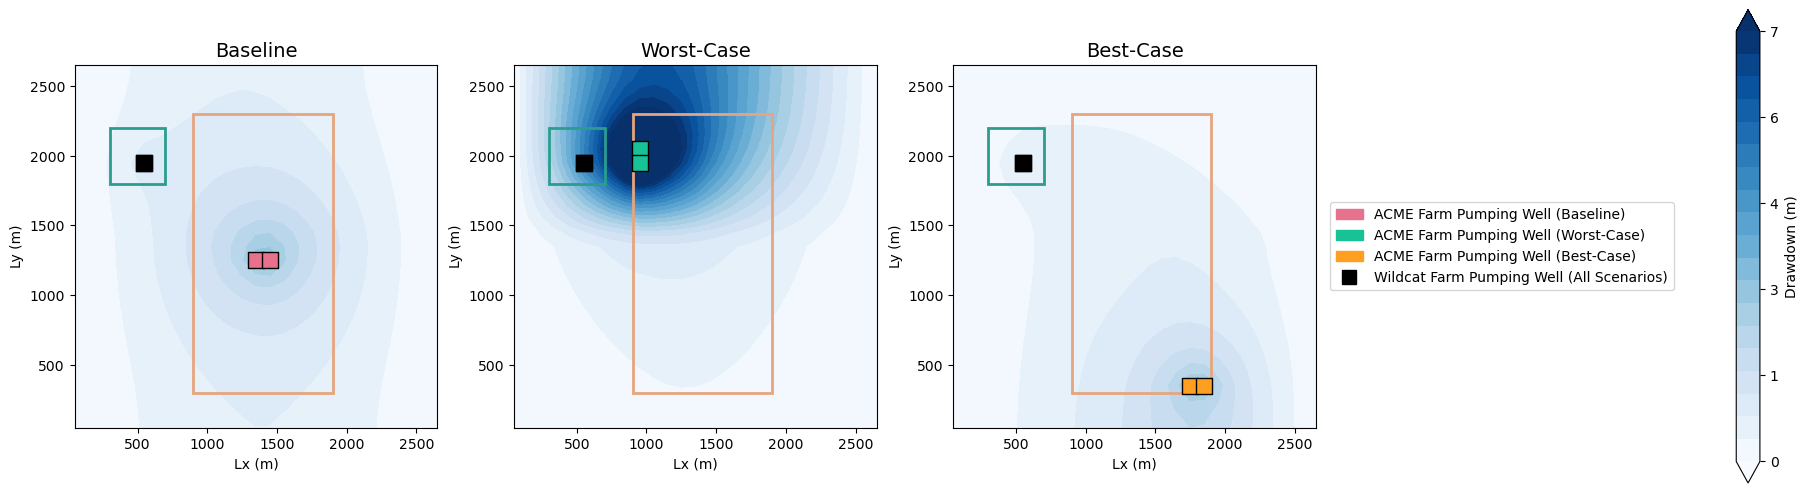

In [24]:
# mapping between display titles and keys used in heads_scenario / scenario flux dicts
plot_order = [
    ("Baseline", "baseline"),
    ("Worst-Case", "worst"),
    ("Best-Case", "best"),
]

# map model row index to physical y coordinate (top-origin)
xgrid = np.linspace(dx/2, dx*ncol - dx/2, ncol)
ygrid = np.linspace(dy/2, dy*nrow - dy/2, nrow)
def y_of_row(r):
    return ygrid[nrow - 1 - r]

def compute_plot_arrays(head_array):
    Z = head_array[0]
    hleft  = np.mean(Z[:, 0])
    hright = np.mean(Z[:, -1])
    bkgnd_1d = np.linspace(hleft, hright, ncol)
    drawdown = np.tile(bkgnd_1d, (nrow, 1)) - Z
    return np.flipud(Z), np.flipud(drawdown)

all_drawdowns = []
for _, skey in plot_order:
    _, draw = compute_plot_arrays(heads_scenario[skey])
    all_drawdowns.append(draw)
all_stack = np.stack(all_drawdowns)
vmin = np.nanpercentile(all_stack, 1)
vmax = np.nanpercentile(all_stack, 99)
levels = np.linspace(vmin, vmax, 20)

# wells mapping for labels
sp_fluxes_map = {"baseline": sp_fluxes_baseline, "worst": sp_fluxes_wc, "best": sp_fluxes_bc}
def get_wells_for_scenario(skey):
    sp = sp_fluxes_map.get(skey, {})
    entries = sp.get(0, [])
    out = []
    for e in entries:
        k, r, c, qneg = int(e[0]), int(e[1]), int(e[2]), float(e[3])
        out.append((k, r, c, -qneg))
    return out

def farm_rect_coords(r1, r2, c1, c2):
    left = xgrid[c1] - dx/2
    width = (c2 - c1 + 1) * dx
    bottom = y_of_row(r2) - dy/2
    height = (r2 - r1 + 1) * dy
    return left, bottom, width, height

farmA_rect = farm_rect_coords(r1_a, r2_a, c1_a, c2_a)
farmB_rect = farm_rect_coords(r1_b, r2_b, c1_b, c2_b)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
X, Y = np.meshgrid(xgrid, ygrid)
marker_for = {"Baseline":"s", "Worst-Case":"s", "Best-Case":"s"}
color_for  = {"Baseline":"#e8718d", "Worst-Case":"#18C297", "Best-Case":"#ff9f21"}

for ax, (title, skey) in zip(axes, plot_order):
    Z_plot, draw_plot = compute_plot_arrays(heads_scenario[skey])
    cf = ax.contourf(X, Y, draw_plot, levels=levels, cmap='Blues', extend='both')
    # farms
    ax.add_patch(Rectangle((farmA_rect[0], farmA_rect[1]), farmA_rect[2], farmA_rect[3],
                           linewidth=2, edgecolor="#2a9d8f", facecolor='none', zorder=6))
    ax.add_patch(Rectangle((farmB_rect[0], farmB_rect[1]), farmB_rect[2], farmB_rect[3],
                           linewidth=2, edgecolor="#e6a57e", facecolor='none', zorder=6))
    # wells for this scenario (with pumping rates)
    for (k, r, c, q) in get_wells_for_scenario(skey):
        if not (0 <= r < nrow and 0 <= c < ncol): continue
        wx = xgrid[c]; wy = y_of_row(r)
        ax.scatter(wx, wy, s=120, c=color_for[title], marker=marker_for[title], edgecolor='k', zorder=7)
    # overplot black Wildcat well marker (always)
    wx = xgrid[5]; wy = y_of_row(7)
    ax.scatter(wx, wy, s=140, c='k', marker='s', edgecolors='k', linewidths=1.0, zorder=11)
    ax.set_title(title, fontsize=14); ax.set_xlabel('Lx (m)'); ax.set_ylabel('Ly (m)')
    ax.set_aspect('equal', adjustable='box')

# colorbar
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.8, extend='both')
ticks = np.linspace(vmin, vmax, 6)
cbar.set_ticks(ticks)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(round(x))}"))
cbar.set_label('Drawdown (m)')

# legend
handles = [
    mpatches.Patch(color="#e8718d", label='ACME Farm Pumping Well (Baseline)'),
    mpatches.Patch(color="#18C297", label='ACME Farm Pumping Well (Worst-Case)'),
    mpatches.Patch(color="#ff9f21", label='ACME Farm Pumping Well (Best-Case)'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='k', markeredgecolor='k',
           markersize=10, label='Wildcat Farm Pumping Well (All Scenarios)')
]
axes[-1].legend(handles=handles, bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=True)

plt.show()

In [25]:
def find_cbc_for_scenario(scen):
    scen_ws = os.path.join(base_ws, scen)
    if not os.path.isdir(scen_ws):
        return None
    # try to parse .nam for a .cbc reference
    nam_path = os.path.join(scen_ws, f"{model_base_name}_{scen}.nam")
    if os.path.isfile(nam_path):
        with open(nam_path, 'r', errors='ignore') as fh:
            for line in fh:
                toks = line.split()
                for tok in toks:
                    if tok.lower().endswith('.cbc'):
                        candidate = os.path.join(scen_ws, tok.strip())
                        if os.path.isfile(candidate):
                            return candidate
    # fallback: find any .cbc in the folder
    for fn in os.listdir(scen_ws):
        if fn.lower().endswith('.cbc'):
            return os.path.join(scen_ws, fn)
    return None

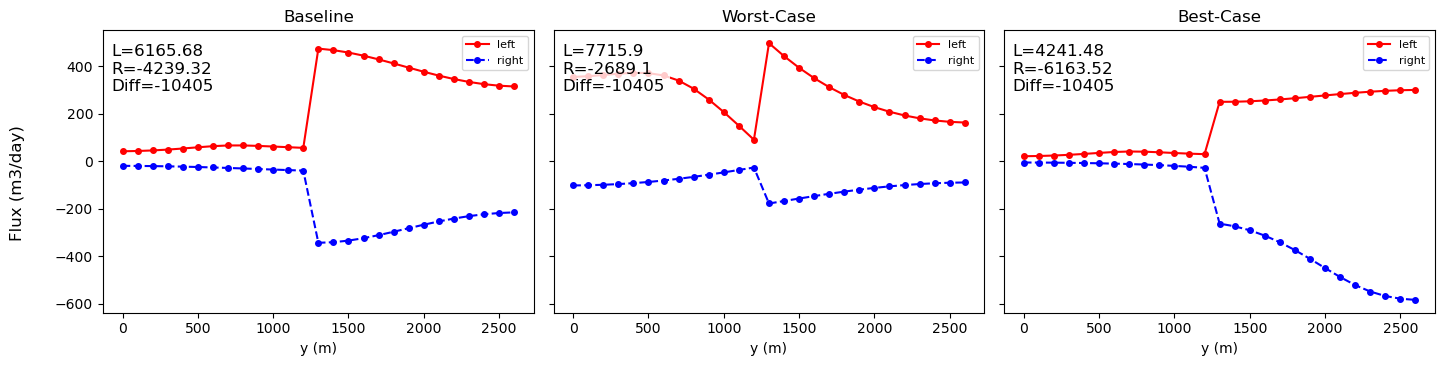

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_scenarios_multi_panel_simple(scenarios, ncols=3, show=True):

    # mapping for nicer titles
    title_map = {'baseline': 'Baseline', 'worst': 'Worst-Case', 'best': 'Best-Case'}

    results = {}
    n = len(scenarios)
    if n == 0:
        return results

    ncols = min(ncols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
    axes = np.array(axes).reshape(nrows, ncols)

    for idx, scen in enumerate(scenarios):
        ax = axes[idx // ncols, idx % ncols]
        results[scen] = {'cbc_path': None, 'leftflux': None, 'rightflux': None,
                         'left_tot': None, 'right_tot': None, 'diff': None, 'error': None}
        try:
            cbc_path = find_cbc_for_scenario(scen)
            if not cbc_path:
                ax.text(0.5, 0.5, f"No .cbc in {os.path.join(base_ws, scen)}",
                        ha='center', va='center', transform=ax.transAxes)
                ax.set_title(title_map.get(scen, scen.title()))
                results[scen]['error'] = 'no_cbc'
                continue

            budg = bf.CellBudgetFile(cbc_path)
            times = budg.get_times()
            if not times:
                raise RuntimeError("no times in cbc")
            totim = times[-1]

            frf = budg.get_data(text='flow right face', totim=totim)
            if frf is None:
                raise RuntimeError("flow right face not found")

            flux_vals = np.squeeze(frf)
            if flux_vals.ndim == 1:
                flux_vals = flux_vals.reshape((-1, 1))

            leftflux = np.round(flux_vals[:, 0], 4)
            right_idx = -2 if flux_vals.shape[1] >= 2 else -1
            rightflux = np.round(flux_vals[:, right_idx], 4)

            m = leftflux.size
            try:
                x = np.linspace(0, (m - 1) * dx, m)   # uses dx if available
            except Exception:
                x = np.arange(m)

            # both lines use circle markers
            ax.plot(x, leftflux, marker='o', linestyle='-', color='red', markersize=4, label='left')
            ax.plot(x, rightflux, marker='o', linestyle='--', color='blue', markersize=4, label='right')
            ax.set_xlabel('y (m)')

            left_tot = float(np.sum(leftflux))
            right_tot = float(np.sum(rightflux))
            diff = right_tot - left_tot

            # simple title from mapping
            ax.set_title(title_map.get(scen, scen.title()))

            # larger inside annotation
            ax.text(0.02, 0.95,
                    f"L={left_tot:.6g}\nR={right_tot:.6g}\nDiff={diff:.6g}",
                    transform=ax.transAxes, fontsize=12, va='top',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

            ax.legend(fontsize=8)

            results[scen].update({
                'cbc_path': cbc_path,
                'leftflux': leftflux,
                'rightflux': rightflux,
                'left_tot': left_tot,
                'right_tot': right_tot,
                'diff': diff
            })

        except Exception as e:
            results[scen]['error'] = str(e)
            ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title_map.get(scen, scen.title()))

    # hide unused axes
    total_slots = nrows * ncols
    for extra_idx in range(n, total_slots):
        r, c = divmod(extra_idx, ncols)
        axes[r, c].axis('off')

    # common y-axis label
    fig.text(0.04, 0.5, 'Flux (m3/day)', va='center', rotation='vertical', fontsize=12)

    fig.tight_layout(rect=[0.06, 0.03, 1, 0.97])

    if show:
        try:
            plt.show()
        except Exception:
            pass

    return results

results = plot_scenarios_multi_panel_simple(scenarios, ncols=3)